In [1]:
# !pip install causalml
# !pip install duecredit

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict
from causalml.dataset import synthetic_data
from causalml.inference.meta import (
    BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
)
from sklearn.metrics import mean_absolute_error, mean_squared_error


## 0. 데이터 생성 Synthetic Data

In [3]:
# ============= 1. Synthetic Data =============
num_features = 5
Y, X, T, tau, b, e = synthetic_data(mode=1, n=1000, p=num_features)


## 1. S-learner (Single Model)
- **개념**: X와 T(처치)를 합쳐 하나의 모델로 학습
- **수식**:  
  $\hat{Y} = f(X, T)$
- **CATE 계산**:  
  $\text{CATE}(x) = f(x, 1) - f(x, 0)$
- **특징**:  
  - 단순, 데이터 적을 때 적합  
  - 상호작용항(optional) 추가 가능  
  - T와 X 상호작용 잘 못 잡으면 편향 가능  
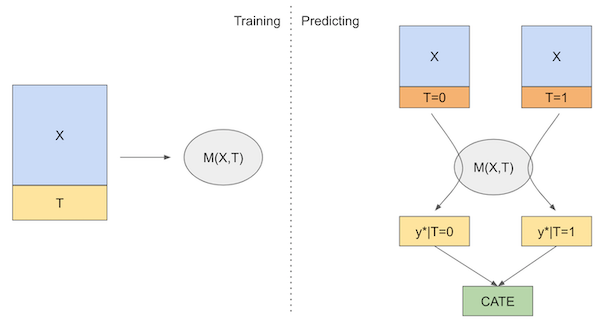


In [4]:
# ============= 1. S-learner =============
def s_learner(X, T, Y, X_test, model=LinearRegression(), add_interaction=True):
    """
    S-learner 직접구현
    - add_interaction=True: X, T, X*T(상호작용항) 포함
    - add_interaction=False: X, T만 사용 (상호작용항 없음)
    """
    if add_interaction:
        XT = X * T.reshape(-1, 1)
        X_train = np.concatenate([X, T.reshape(-1, 1), XT], axis=1)
        XT0 = X_test * 0
        XT1 = X_test * 1
        X_test_t0 = np.concatenate([X_test, np.zeros((len(X_test), 1)), XT0], axis=1)
        X_test_t1 = np.concatenate([X_test, np.ones((len(X_test), 1)), XT1], axis=1)
    else:
        X_train = np.concatenate([X, T.reshape(-1, 1)], axis=1)
        X_test_t0 = np.concatenate([X_test, np.zeros((len(X_test), 1))], axis=1)
        X_test_t1 = np.concatenate([X_test, np.ones((len(X_test), 1))], axis=1)
    model.fit(X_train, Y)
    y0_pred = model.predict(X_test_t0)
    y1_pred = model.predict(X_test_t1)
    return y1_pred - y0_pred

# 직접구현 S-learner (상호작용항 O/X)
cate_s_with_inter = s_learner(X, T, Y, X, add_interaction=True)   # 상호작용항 포함
cate_s_no_inter   = s_learner(X, T, Y, X, add_interaction=False)  # 상호작용항 미포함

# causalml S-learner
slearner_pkg = BaseSRegressor(learner=LinearRegression())
slearner_pkg.fit(X=X, treatment=T, y=Y)
cate_s_pkg = slearner_pkg.predict(X=X).flatten()

# 결과 비교
methods = {
    "S-learner(상호작용항)": cate_s_with_inter,
    "S-learner(미포함)": cate_s_no_inter,
    "S-learner(causalML)": cate_s_pkg,
}

print("\n======= 결과 요약 =======")
for name, pred in methods.items():
    mae = mean_absolute_error(tau, pred)
    rmse = np.sqrt(mean_squared_error(tau, pred))
    print(f"{name:>20} | MAE: {mae:.3f} | RMSE: {rmse:.3f} | 예측평균: {pred.mean():.3f} | 표준편차: {pred.std():.3f}")


======= 결과 요약 =======
    S-learner(상호작용항) | MAE: 0.168 | RMSE: 0.197 | 예측평균: 0.660 | 표준편차: 0.225
      S-learner(미포함) | MAE: 0.226 | RMSE: 0.273 | 예측평균: 0.684 | 표준편차: 0.000
 S-learner(causalML) | MAE: 0.226 | RMSE: 0.273 | 예측평균: 0.684 | 표준편차: 0.000



---


## 2. T-learner (Two Model)
- **개념**: T=0, T=1 각각 따로 모델을 두 개 학습
- **수식**:  
  $\hat{\mu}_0(x) = f_0(x)$  
  $\hat{\mu}_1(x) = f_1(x)$
- **CATE 계산**:  
  $\text{CATE}(x) = \hat{\mu}_1(x) - \hat{\mu}_0(x)$
- **특징**:  
  - 집단별 특성 잡는 데 강함  
  - 데이터 많을 때 유리  
  - 그룹 불균형·오버피팅 주의  
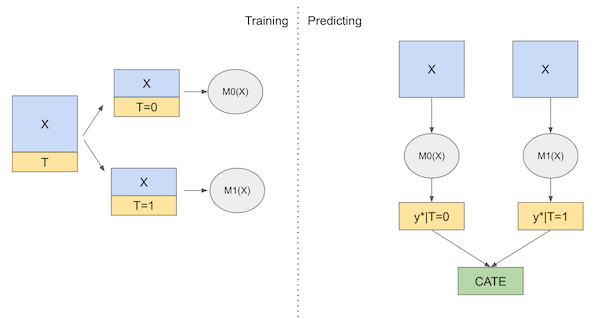
---


In [5]:
# ============= 2. T-learner =============
def t_learner(X, T, Y, X_test, model=LinearRegression()):
    model_treated = LinearRegression()
    model_control = LinearRegression()
    model_treated.fit(X[T==1], Y[T==1])
    model_control.fit(X[T==0], Y[T==0])
    y1_pred = model_treated.predict(X_test)
    y0_pred = model_control.predict(X_test)
    return y1_pred - y0_pred

cate_t_direct = t_learner(X, T, Y, X)

tlearner_pkg = BaseTRegressor(learner=LinearRegression())
tlearner_pkg.fit(X=X, treatment=T, y=Y)
cate_t_pkg = tlearner_pkg.predict(X=X).flatten()

print("\n======= T-learner 결과 =======")
for name, pred in {
    'T-learner(직접구현)': cate_t_direct,
    'T-learner(causalML)': cate_t_pkg
}.items():
    mae = mean_absolute_error(tau, pred)
    rmse = np.sqrt(mean_squared_error(tau, pred))
    print(f"{name:>20} | MAE: {mae:.3f} | RMSE: {rmse:.3f} | 예측평균: {pred.mean():.3f} | 표준편차: {pred.std():.3f}")



======= T-learner 결과 =======
     T-learner(직접구현) | MAE: 0.168 | RMSE: 0.197 | 예측평균: 0.660 | 표준편차: 0.225
 T-learner(causalML) | MAE: 0.168 | RMSE: 0.197 | 예측평균: 0.660 | 표준편차: 0.225


---

## 3. X-learner (Cross-learner)
- **개념**: T-learner로 각 집단의 예측값으로 가짜효과(pseudo effect) 계산 후,  
  이 가짜효과로 각 집단별로 한 번 더 모델링, 성향점수(ps)로 최종 결합
- **수식**:  
  - 집단별 예측  
    $\hat{\mu}_0(x),\ \hat{\mu}_1(x)$
  - 가짜효과  
    $\tilde{\tau}_0 = \hat{\mu}_1(X_{T=0}) - Y_{T=0}$  
    $\tilde{\tau}_1 = Y_{T=1} - \hat{\mu}_0(X_{T=1})$
  - 각각 모델  
    $\tau_0(x),\ \tau_1(x)$
  - 결합  
    $\text{CATE}(x) = p(x)\tau_0(x) + (1-p(x))\tau_1(x)$
- **특징**:  
  - 집단 불균형에 강함  
  - 성향점수(ps)로 가중  
  - 계산 단계 많음  
  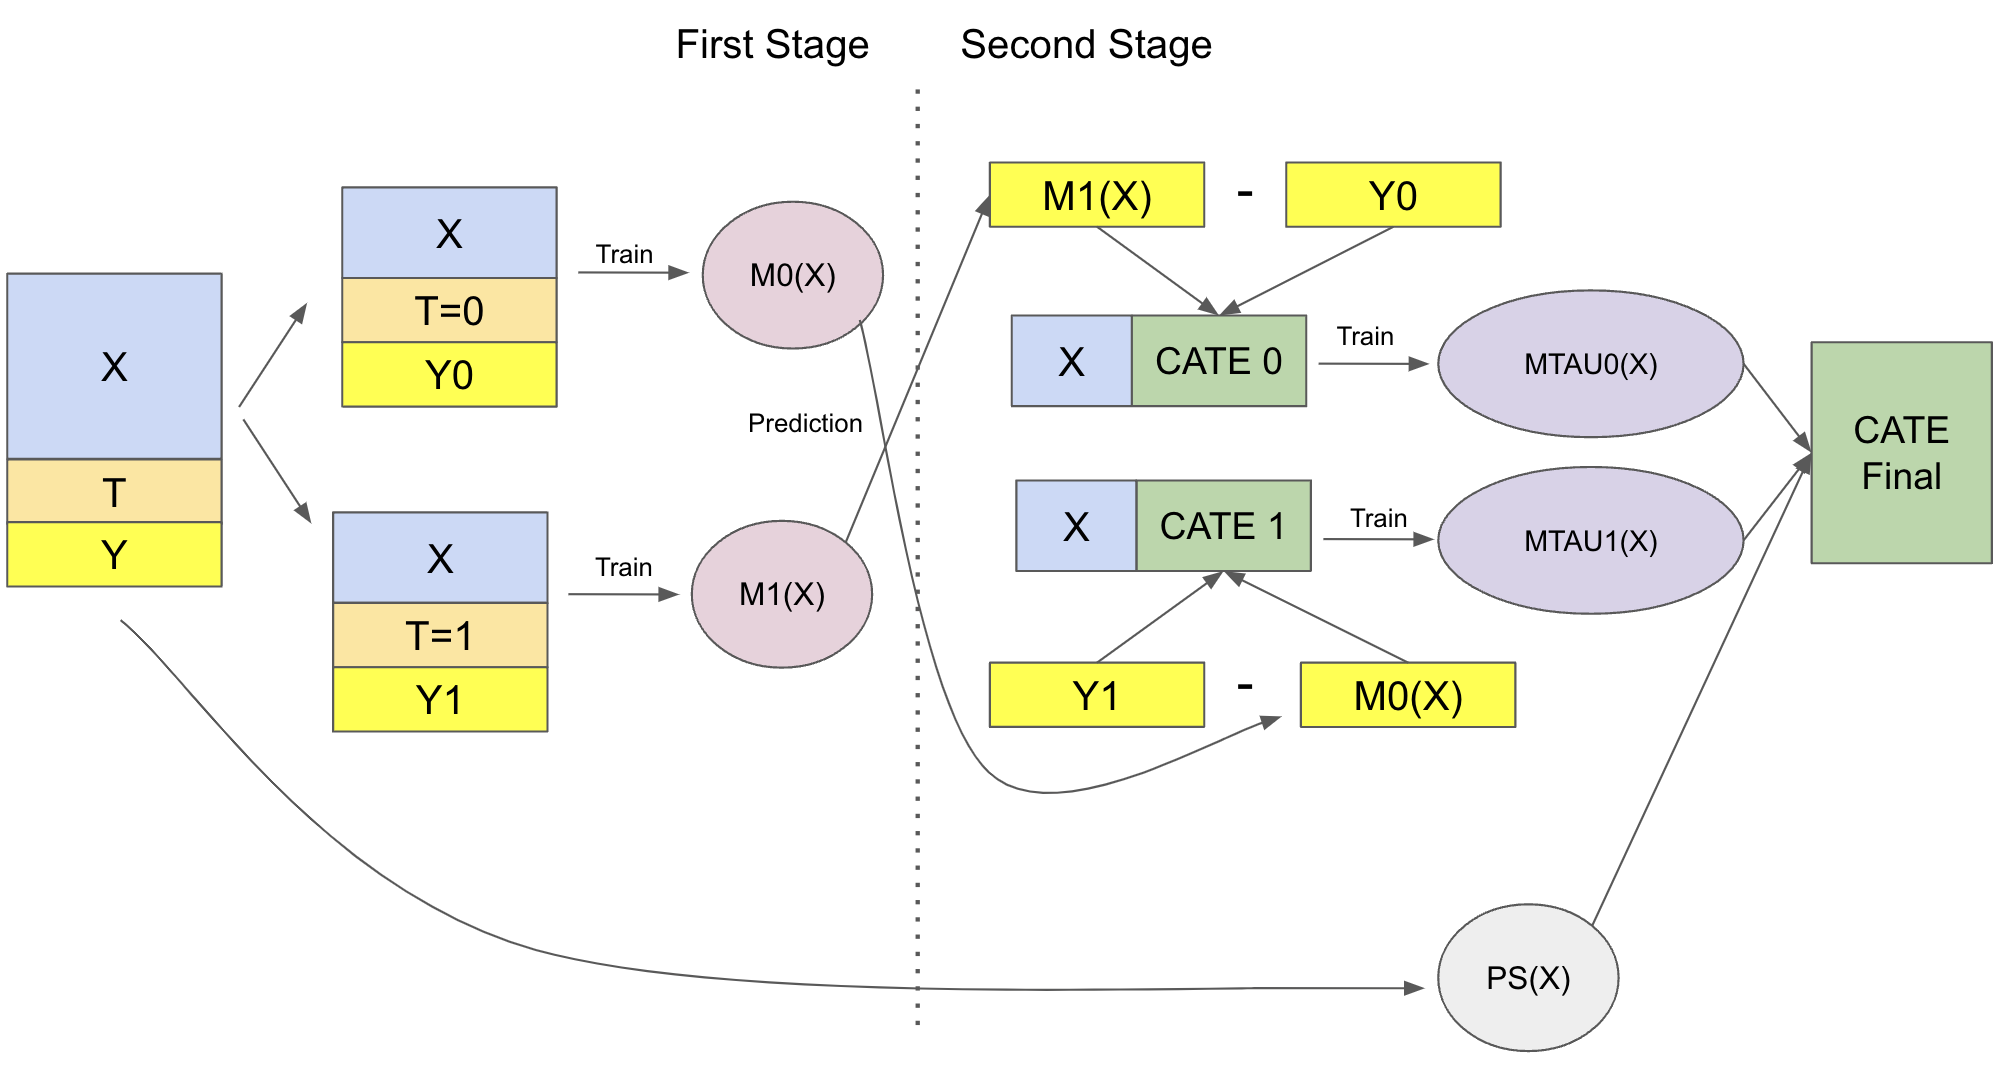

In [6]:
# ============= 3. X-learner =============
def x_learner(X, T, Y, X_test):
    model_treated = LinearRegression().fit(X[T==1], Y[T==1])
    model_control = LinearRegression().fit(X[T==0], Y[T==0])
    d1 = Y[T==1] - model_control.predict(X[T==1])
    d0 = model_treated.predict(X[T==0]) - Y[T==0]
    tau1 = LinearRegression().fit(X[T==1], d1)
    tau0 = LinearRegression().fit(X[T==0], d0)
    p = T.mean()
    cate = p * tau0.predict(X_test) + (1 - p) * tau1.predict(X_test)
    return cate

cate_x_direct = x_learner(X, T, Y, X)

xlearner_pkg = BaseXRegressor(learner=LinearRegression())
xlearner_pkg.fit(X=X, treatment=T, y=Y)
cate_x_pkg = xlearner_pkg.predict(X=X).flatten()

print("\n======= X-learner 결과 =======")
for name, pred in {
    'X-learner(직접구현)': cate_x_direct,
    'X-learner(causalML)': cate_x_pkg
}.items():
    mae = mean_absolute_error(tau, pred)
    rmse = np.sqrt(mean_squared_error(tau, pred))
    print(f"{name:>20} | MAE: {mae:.3f} | RMSE: {rmse:.3f} | 예측평균: {pred.mean():.3f} | 표준편차: {pred.std():.3f}")


======= X-learner 결과 =======
     X-learner(직접구현) | MAE: 0.168 | RMSE: 0.197 | 예측평균: 0.660 | 표준편차: 0.225
 X-learner(causalML) | MAE: 0.168 | RMSE: 0.197 | 예측평균: 0.660 | 표준편차: 0.225




## 4. R-learner (Residual-on-Residual)
- **개념**:  
  Y와 T를 각각 X로 예측해 잔차(오차)로 변환, 잔차끼리 회귀
- **수식**:  
  - 결과 예측  
    $\hat{\mu}(x) = E[Y|X=x]$
  - 성향점수 예측  
    $\hat{e}(x) = P(T=1|X=x)$
  - 잔차  
    $W = T - \hat{e}(X)$  
    $Z = Y - \hat{\mu}(X)$
  - 효과추정  
    $Z = W \cdot \tau(X) + \text{오차}$
- **CATE 계산**:  
  $\tau(x)$
- **특징**:  
  - 잔차 기반, 일반화에 강함  
  - 수식은 복잡해보이지만 원리는 명확  
  - 성향점수, 결과모형 각각 추정 필요  

---

In [26]:
# ============= 4. R-learner =============
def r_learner(X, T, Y, X_test, n_fold=5, random_state=42):
    prop_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=random_state)
    prop_model.fit(X, T)
    p = prop_model.predict_proba(X)[:, 1]
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
    mu_hat = cross_val_predict(LinearRegression(), X, Y, cv=kf, n_jobs=-1)
    W = T - p
    eps = 1e-6
    W_safe = np.where(np.abs(W) < eps, eps, W)
    tau_target = (Y - mu_hat) / W_safe
    weights = W_safe ** 2
    tau_model = LinearRegression()
    tau_model.fit(X, tau_target, sample_weight=weights)
    cate_pred = tau_model.predict(X_test)
    return cate_pred

    
cate_r_direct = r_learner(X, T, Y, X)

rlearner_pkg = BaseRRegressor(learner=LinearRegression())
rlearner_pkg.fit(X=X, treatment=T, y=Y)
cate_r_pkg = rlearner_pkg.predict(X=X).flatten()

print("\n======= R-learner 결과 =======")
for name, pred in {
    'R-learner(직접구현)': cate_r_direct,
    'R-learner(causalML)': cate_r_pkg
}.items():
    mae = mean_absolute_error(tau, pred)
    rmse = np.sqrt(mean_squared_error(tau, pred))
    print(f"{name:>20} | MAE: {mae:.3f} | RMSE: {rmse:.3f} | 예측평균: {pred.mean():.3f} | 표준편차: {pred.std():.3f}")



======= R-learner 결과 =======
     R-learner(직접구현) | MAE: 0.165 | RMSE: 0.202 | 예측평균: 0.630 | 표준편차: 0.315
 R-learner(causalML) | MAE: 0.144 | RMSE: 0.177 | 예측평균: 0.618 | 표준편차: 0.292
